# Part 3 Building the Model

This notebook goes through the process of selecting and building the best model to use with this problem. There are several ML algorithm options available in the SparkML library. As this is a binary classification problem, we will use Logistic Regression, Random Forest and Gradient Boosted Tree classifiers.

The aim here is to train all three kinds of models and then test to see which provides the best results. The next step is to optimise i.e. the chosen models hyper parameters to then have the best option for solving this problem. 

## Start the Spark Session
Note the changes to `spark.executor.memory` and `spark.executor.instances`. SparkML processes are more memory intensive and therefore require a different configuration to run efficiently.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession\
    .builder\
    .appName("Airline ML")\
    .config("spark.executor.memory","8g")\
    .config("spark.executor.cores","2")\
    .config("spark.driver.memory","6g")\
    .config("spark.dynamicAllocation.enabled","false")\
    .config("spark.yarn.access.hadoopFileSystems","s3a://prod-cdptrialuser19-trycdp-com/cdp-lake/data/")\
    .getOrCreate()

## Import the Data
The data that is imported was the smaller data set created in Part 2. This is now stored in S3 in parquet format and will therefore load much quicker. To get the larger ML jobs to complete in a reasonable amount of time for a workshop audience, there total data set size is limited to approx 100,000 sampled rows.

In [2]:
# flight_df_original =spark.read.parquet(
#   "s3a://prod-cdptrialuser19-trycdp-com/cdp-lake/data/airlines/airline_parquet",
# )

flight_df_original = spark.sql("select * from smaller_flight_table")

flight_df = flight_df_original.na.drop().sample(1/600,seed=111)
flight_df.persist()

DataFrame[WEEK: double, FL_DATE: timestamp, OP_CARRIER: string, OP_CARRIER_FL_NUM: string, ORIGIN: string, DEST: string, CRS_DEP_TIME: string, CRS_ARR_TIME: string, CANCELLED: double, CRS_ELAPSED_TIME: double, DISTANCE: double]

In [3]:
#Adding a link to the Spark UI for demo purposes
from IPython.core.display import HTML
import os
HTML('<a href="http://spark-{}.{}">Spark UI</a>'.format(os.getenv("CDSW_ENGINE_ID"),os.getenv("CDSW_DOMAIN")))

In [4]:
#spark.stop()

In [5]:
flight_df.printSchema()

root
 |-- WEEK: double (nullable = true)
 |-- FL_DATE: timestamp (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: string (nullable = true)
 |-- CRS_ARR_TIME: string (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)



## Basic Feature Engineering
Before applying any training to an ML algorithm, you need to check if the format of columns in your dataset will work with the chosen algorithm. The first change that we need to make is extracting the hour of the day from the time. This is based on an assumption of seasonality during the day. The second change is to extract week of the year using `weekofyear`. The ML aglorithms needs floating point numbers for optimal internal matrix maths, therefore these two new columns are cast using `cast('double')`.

> HANDY TIP
> 
> Each new release of PySpark brings with it more useful functions that makes it easier to do things that you had to use a UDF to do.
> Even with Apache Arrow used for memory storage, using a Python UDF in a pyspark tranform is going to be slower than running pure Spark functions. After spending some time reading through the pyspark function list, I found that I could do what my udf did using a the `when` and `otherwise` functions.

In [6]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf,substring,weekofyear,concat,col,when,length,lit,hour

#No longer needed
#convert_time_to_hour = udf(lambda x: x if len(x) == 4 else "0{}".format(x),StringType())

flight_df = flight_df\
    .withColumn(
        'CRS_DEP_HOUR',
        when(
            length(col("CRS_DEP_TIME")) == 4,col("CRS_DEP_TIME")
        )\
        .otherwise(concat(lit("0"),col("CRS_DEP_TIME")))
    )

flight_df = flight_df.withColumn('CRS_DEP_HOUR',col('CRS_DEP_TIME').cast('double'))
flight_df = flight_df.withColumn('WEEK',weekofyear('FL_DATE').cast('double'))

In [7]:
flight_df.printSchema()

root
 |-- WEEK: double (nullable = true)
 |-- FL_DATE: timestamp (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: string (nullable = true)
 |-- CRS_ARR_TIME: string (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_HOUR: double (nullable = true)



## Additional Feature Indexing and Encoding

The next feature engineering requirement is to convert the categorical variables into a numeric form. The `OP_CARRIER`,`ORIGIN` and `DEST` columns are the ones that will be used. All three are `string` type categorical variables. There are 2 methods of dealing with these, one is using a [String Indexer](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.StringIndexer) and the other is using a [One Hot Encoder](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.OneHotEncoder). Logsitic Regression requires one hot encoding, [tree based algorithims do not](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/). The code below creates a [Spark Pipeline](https://spark.apache.org/docs/latest/ml-pipeline.html) that assembles the process to get the columns needed, do the indexing and encoding and create an packaged vector that the various models will be trained on.

> HANDY TIP
>
> `OneHotEncoderEstimator` is a function introduced in Spark 2.3 and works on severnal indexed columns in one go, rather than having to do one `OneHotEncoder` per indexed feature.

In [8]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, OneHotEncoderEstimator

numeric_cols = ["CRS_ELAPSED_TIME","DISTANCE","WEEK","CRS_DEP_HOUR"]

op_carrier_indexer = StringIndexer(inputCol ='OP_CARRIER', outputCol = 'OP_CARRIER_INDEXED',handleInvalid="keep")

origin_indexer = StringIndexer(inputCol ='ORIGIN', outputCol = 'ORIGIN_INDEXED',handleInvalid="keep")

dest_indexer = StringIndexer(inputCol ='DEST', outputCol = 'DEST_INDEXED',handleInvalid="keep")

indexer_encoder = OneHotEncoderEstimator(
    inputCols = ['OP_CARRIER_INDEXED','ORIGIN_INDEXED','DEST_INDEXED'],
    outputCols= ['OP_CARRIER_ENCODED','ORIGIN_ENCODED','DEST_ENCODED']
)

input_cols=[
    'OP_CARRIER_ENCODED',
    'ORIGIN_ENCODED',
    'DEST_ENCODED'] + numeric_cols

assembler = VectorAssembler(
    inputCols = input_cols,
    outputCol = 'features')

from pyspark.ml import Pipeline

pipeline = Pipeline(
    stages=[
        op_carrier_indexer,
        origin_indexer,
        dest_indexer,
        indexer_encoder,
        assembler]
)


## Create the Training and Test Datasets
Once the pipeline has been built the next step is to `fit` the pipeline to the data, and then `transform` it into the final vector form. There after the data needs to split into a test and training set. This is done using `randomSplit`

In [9]:
pipelineModel = pipeline.fit(flight_df)
model_df = pipelineModel.transform(flight_df)
selectedCols = ['CANCELLED', 'features']# + cols
model_df = model_df.select(selectedCols)
model_df.printSchema()
(train, test) = model_df.randomSplit([0.7, 0.3])

root
 |-- CANCELLED: double (nullable = true)
 |-- features: vector (nullable = true)



## Model 1 - Logistic Regression
Now that the vector is assembled and ready to run, the first model we will try is good old faithful logsitic regression.

_Note: this is a bit too accruate to be considered valid_

In [10]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'CANCELLED', maxIter=10)

lrModel = lr.fit(train)

In [11]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictionslr = lrModel.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="CANCELLED",metricName="areaUnderROC")
evaluator.evaluate(predictionslr)

0.6274369134030477

## Save the Pipeline model
This next cell writes the fitted pipeline model back to S3 so it can be used for other processes to build/trainin different models.

In [12]:
#pipelineModel.write().overwrite().save("s3a://ml-field/demo/flight-analysis/data/models/pipeline_model")

## Rebuild the Pipeline
For the tree based classifiers, the data does not need to be one hot encoded. Being able to use the string indexed values significantly reduces the dimensionality of the feature vecotor and vastly improves processing time.

In [13]:
input_cols = [
    'OP_CARRIER_INDEXED',
    'ORIGIN_INDEXED',
    'DEST_INDEXED'] + numeric_cols

assembler = VectorAssembler(
    inputCols = input_cols,
    outputCol = 'features')

pipeline = Pipeline(
    stages=[
        op_carrier_indexer,
        origin_indexer,
        dest_indexer,
        assembler]
)

pipelineModel = pipeline.fit(flight_df)

model_df = pipelineModel.transform(flight_df)
selectedCols = ['CANCELLED', 'features']
model_df = model_df.select(selectedCols)
model_df.printSchema()
(train, test) = model_df.randomSplit([0.7, 0.3])

root
 |-- CANCELLED: double (nullable = true)
 |-- features: vector (nullable = true)



## Model 2 - Random Forest
The `RandomForestClassifier` is run on the updated pipeline and the results are really bad. Its bad performance is likely because of the large number of categories in the categorical variables. To get it to even run, the `maxBins` setting had to be increased to 390, which far above the default of 32.

In [14]:
from pyspark.ml.classification import RandomForestClassifier

rfclassifier = RandomForestClassifier(labelCol = 'CANCELLED', featuresCol = 'features', maxBins=390)
rfmodel = rfclassifier.fit(train)

In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictionsrf = rfmodel.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="CANCELLED",metricName="areaUnderROC")
evaluator.evaluate(predictionsrf)

0.6317127255759166

## Model 2 - Gradient Boosted Tree
The GBTClassifier ran for the longest of all three algorithms but did perform significantly better than the the random forest.

In [16]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10,featuresCol = 'features', labelCol = 'CANCELLED', maxBins=390)

gbtModel = gbt.fit(train)

In [17]:
predictionsgbt = gbtModel.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="CANCELLED",metricName="areaUnderROC")
evaluator.evaluate(predictionsgbt)

0.655144607966833

## Optimising The Model
The final step is to pick the model that peformed the best and then try optimising the various hyper parameters to see if the model's performance can be improved. For linear regression the three parameters that can have a material difference are:

+ `regParam`
+ `elasticNetParam`
+ `maxIter`

To get a list of all the parameters in a model, run `print(<your model object>.explainParams())`.

In [18]:
print(lrModel.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2) (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial. (default: auto)
featuresCol: features column name (default: features, current: features)
fitIntercept: whether to fit an intercept term (default: True)
labelCol: label column name (default: label, current: CANCELLED)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. (undefined)
maxIter: maximum number of iterations (>= 0) (default: 100, current: 10)
predictionCol: prediction column name (default: prediction)
probabilityCol: Column name f

In [19]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(lrModel.maxIter, [5, 10,100])
             .addGrid(lrModel.regParam, [0.0, 0.01, 0.1])
             .addGrid(lrModel.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2, parallelism=3)

cvModel = cv.fit(train)

In [20]:
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.6266503036791601

In [21]:
print("regParam = {}".format(cvModel.bestModel._java_obj.getRegParam()))
print("elasticNetParam = {}".format(cvModel.bestModel._java_obj.getElasticNetParam()))
print("maxIter = {}".format(cvModel.bestModel._java_obj.getMaxIter()))

regParam = 0.0
elasticNetParam = 1.0
maxIter = 100


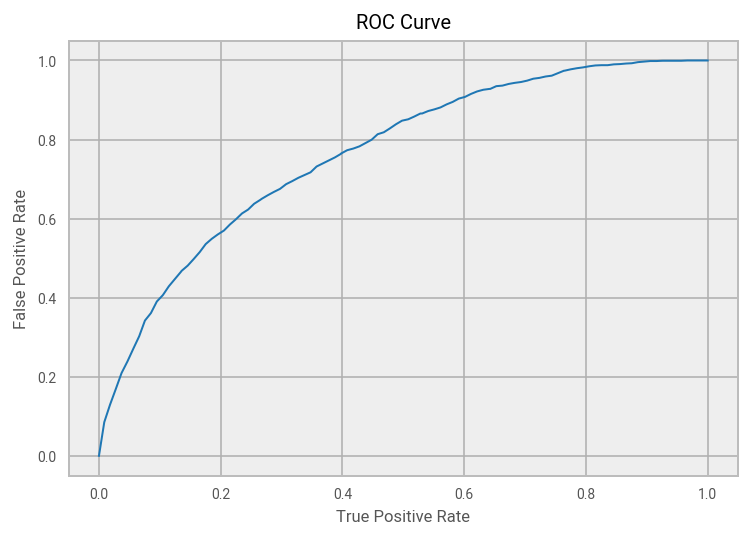

In [23]:
import matplotlib.pyplot as plt 
#trainingSummary = cvModel.bestModel.summary
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
def plotter():
    plt.plot(roc['FPR'],roc['TPR'])
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    plt.title('ROC Curve')
plotter()
#print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))